# Análisis Completo de Datos de Bancarrota

En este notebook realizaremos un análisis completo de los datos de bancarrota, incluyendo:
- Análisis exploratorio de datos
- Visualización de distribuciones
- Análisis de correlaciones
- Análisis de componentes principales
- Importancia de variables

In [17]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]

# Configurar directorio de visualizaciones
import os
os.makedirs('../visualizaciones1', exist_ok=True)

## 1. Carga y Exploración Inicial de Datos

In [18]:
print("Cargando datos...")
train_data = pd.read_csv('../archivos/train_data.csv')
test_data = pd.read_csv('../archivos/test_data.csv')

# Mostrar información básica
print("\nInformación del conjunto de entrenamiento:")
print(f"Número de filas: {train_data.shape[0]}")
print(f"Número de columnas: {train_data.shape[1]}")
print("\nInformación del conjunto de prueba:")
print(f"Número de filas: {test_data.shape[0]}")
print(f"Número de columnas: {test_data.shape[1]}")

Cargando datos...

Información del conjunto de entrenamiento:
Número de filas: 2050
Número de columnas: 65

Información del conjunto de prueba:
Número de filas: 500
Número de columnas: 64


## 2. Análisis de la Variable Objetivo

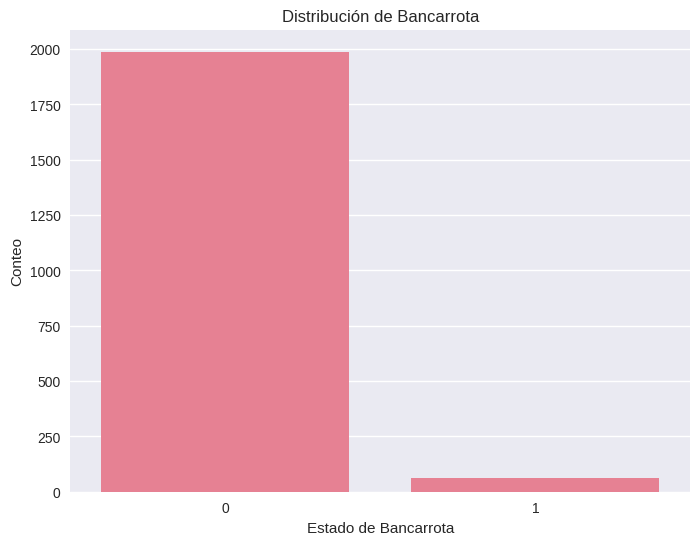


Proporciones de bancarrota:
Bankruptcy
0    0.969756
1    0.030244
Name: proportion, dtype: float64


In [19]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Bankruptcy', data=train_data)
plt.title('Distribución de Bancarrota')
plt.xlabel('Estado de Bancarrota')
plt.ylabel('Conteo')
plt.savefig('../visualizaciones/01_distribucion_bancarrota.png')
plt.show()

# Calcular proporciones
proporciones = train_data['Bankruptcy'].value_counts(normalize=True)
print("\nProporciones de bancarrota:")
print(proporciones)

## 3. Análisis de Variables Numéricas

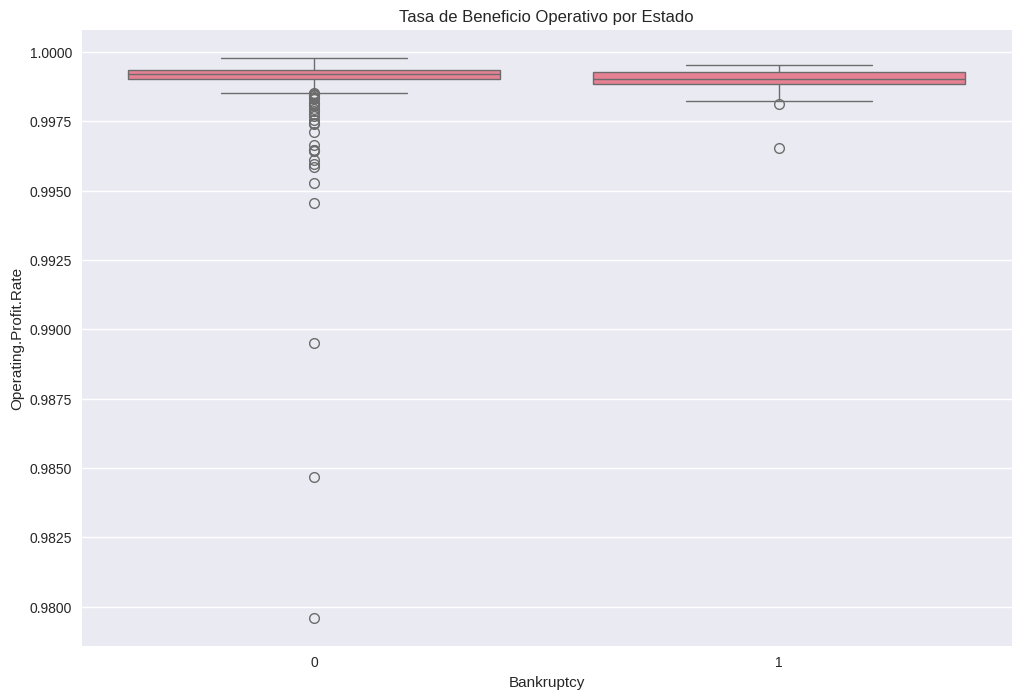

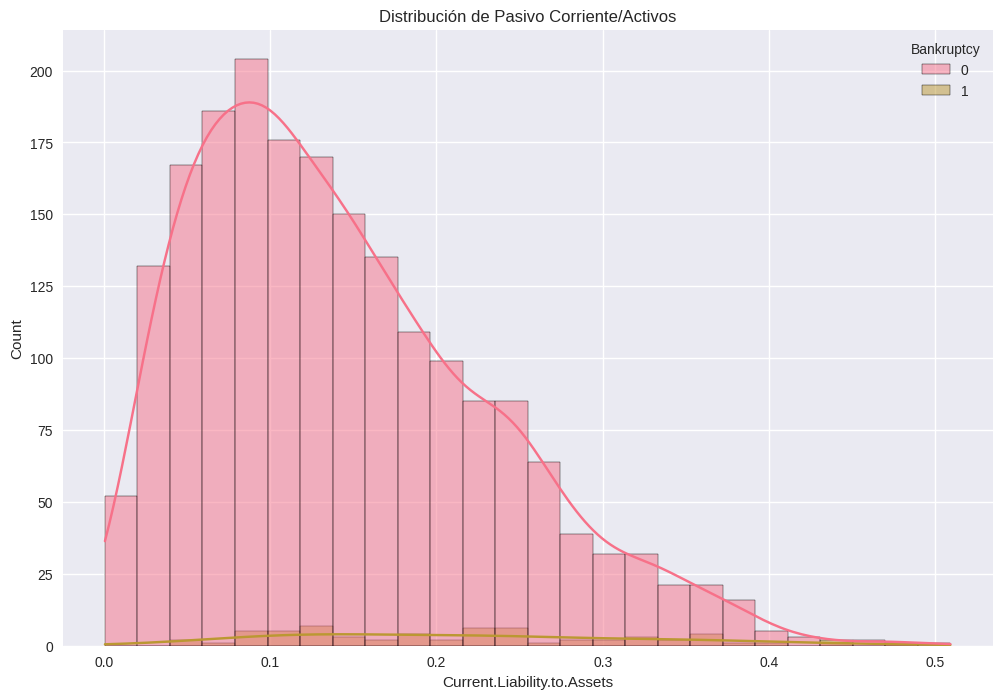

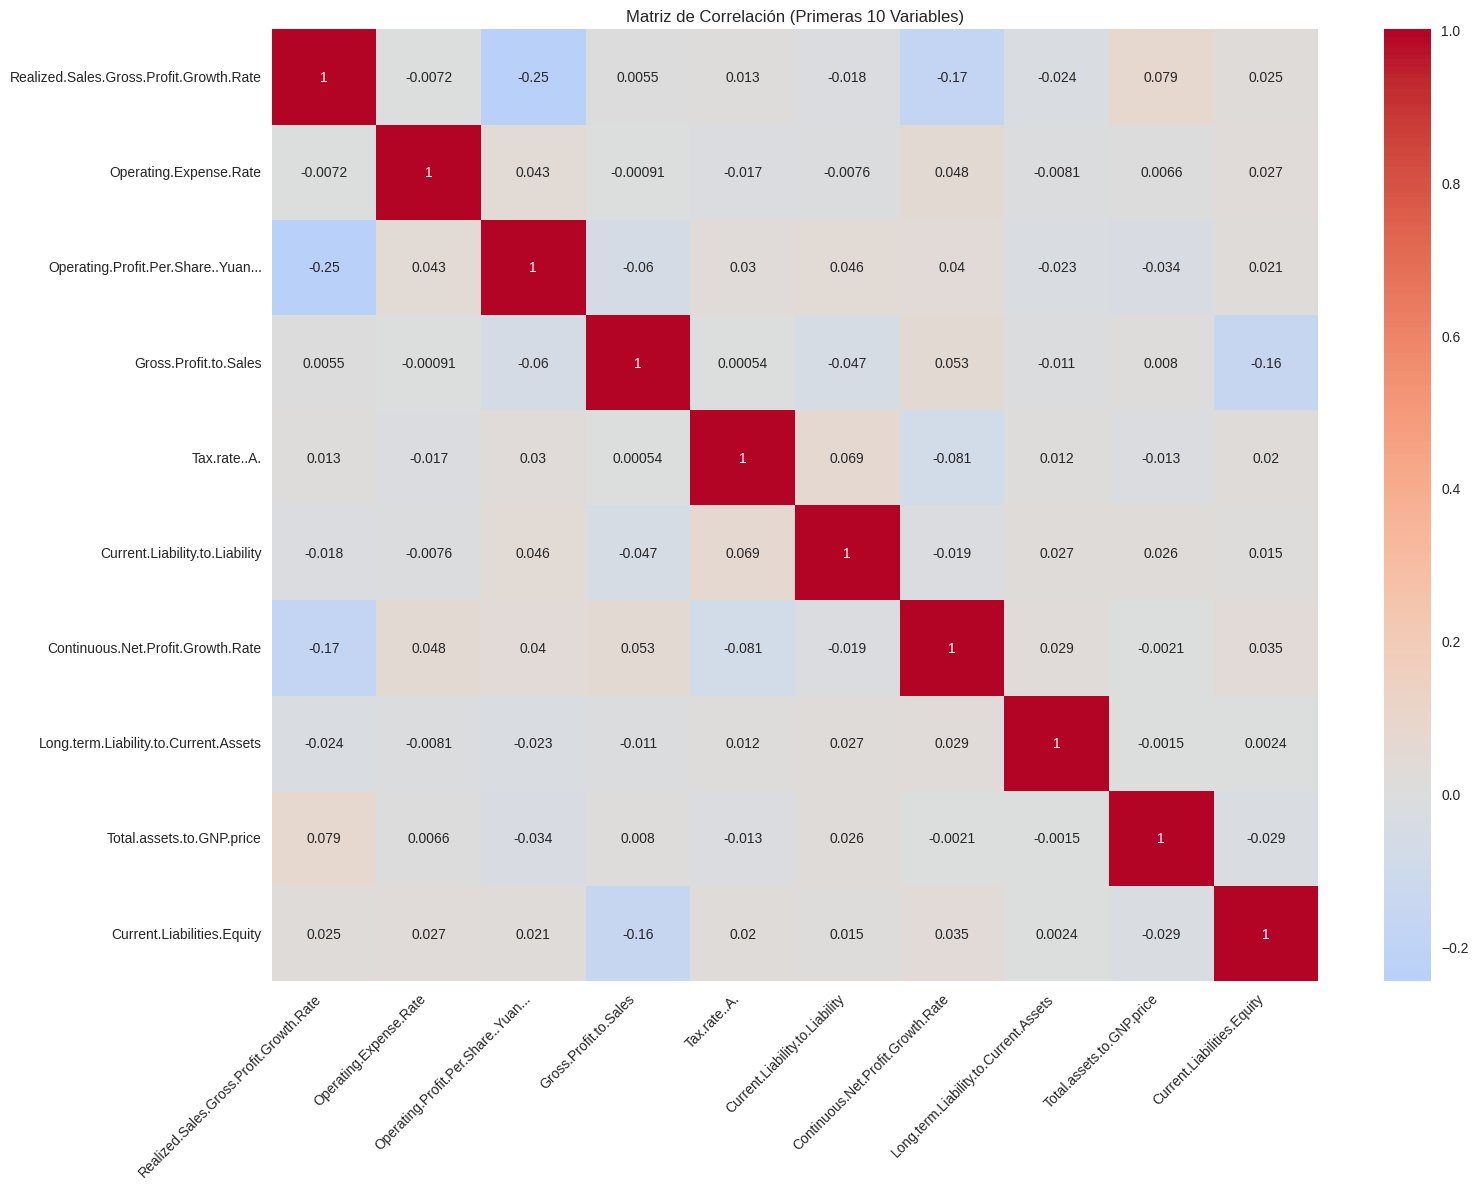

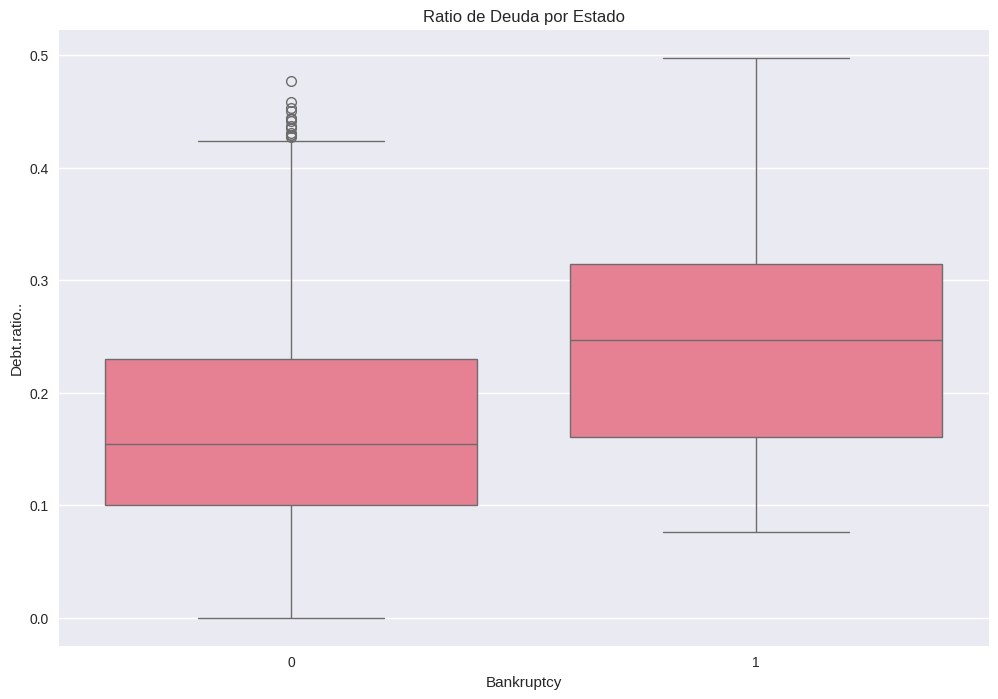

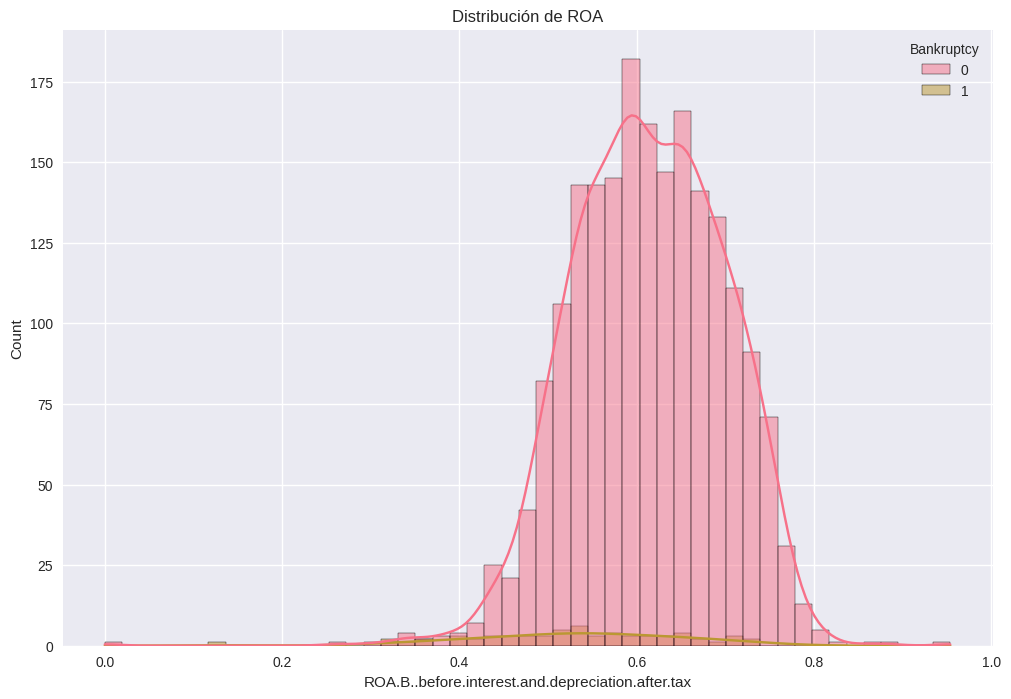

In [20]:
# Seleccionar variables numéricas
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('ID')  # Excluir ID

# Boxplot de lucro operacional
plt.figure(figsize=(12, 8))
sns.boxplot(x='Bankruptcy', y='Operating.Profit.Rate', data=train_data)
plt.title('Tasa de Beneficio Operativo por Estado')
plt.savefig('../visualizaciones/02_beneficio_operativo.png')
plt.show()

# Histograma de passivo corrente
plt.figure(figsize=(12, 8))
sns.histplot(data=train_data, x='Current.Liability.to.Assets', 
            hue='Bankruptcy', kde=True)
plt.title('Distribución de Pasivo Corriente/Activos')
plt.savefig('../visualizaciones/03_pasivo_corriente.png')
plt.show()

# Matriz de correlação inicial
plt.figure(figsize=(16, 12))
corr_matrix = train_data.iloc[:, 2:12].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación (Primeras 10 Variables)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../visualizaciones/04_correlacion_inicial.png')
plt.show()

# Boxplot de ratio de dívida
plt.figure(figsize=(12, 8))
sns.boxplot(x='Bankruptcy', y='Debt.ratio..', data=train_data)
plt.title('Ratio de Deuda por Estado')
plt.savefig('../visualizaciones/05_ratio_deuda.png')
plt.show()

# Histograma de ROA
plt.figure(figsize=(12, 8))
sns.histplot(data=train_data, x='ROA.B..before.interest.and.depreciation.after.tax', 
            hue='Bankruptcy', kde=True)
plt.title('Distribución de ROA')
plt.savefig('../visualizaciones/06_distribucion_roa.png')
plt.show()

## 4. Análisis de Correlación


Top 10 variables más positivamente correlacionadas con Bancarrota:
Bankruptcy                               1.000000
Debt.ratio..                             0.151972
Current.Liability.to.Current.Assets      0.151521
Current.Liability.to.Assets              0.142689
Liability.Assets.Flag                    0.125095
Revenue.per.person                       0.125095
Quick.Ratio                              0.125083
Long.term.Liability.to.Current.Assets    0.088551
Total.expense.Assets                     0.074570
Equity.to.Long.term.Liability            0.061244
Borrowing.dependency                     0.055949
Name: Bankruptcy, dtype: float64

Top 10 variables más negativamente correlacionadas con Bancarrota:
Persistent.EPS.in.the.Last.Four.Seasons             -0.081034
Net.Income.to.Stockholder.s.Equity                  -0.092259
Net.Value.Per.Share..B.                             -0.105821
Cash.Total.Assets                                   -0.108185
Quick.Assets.Total.Assets        

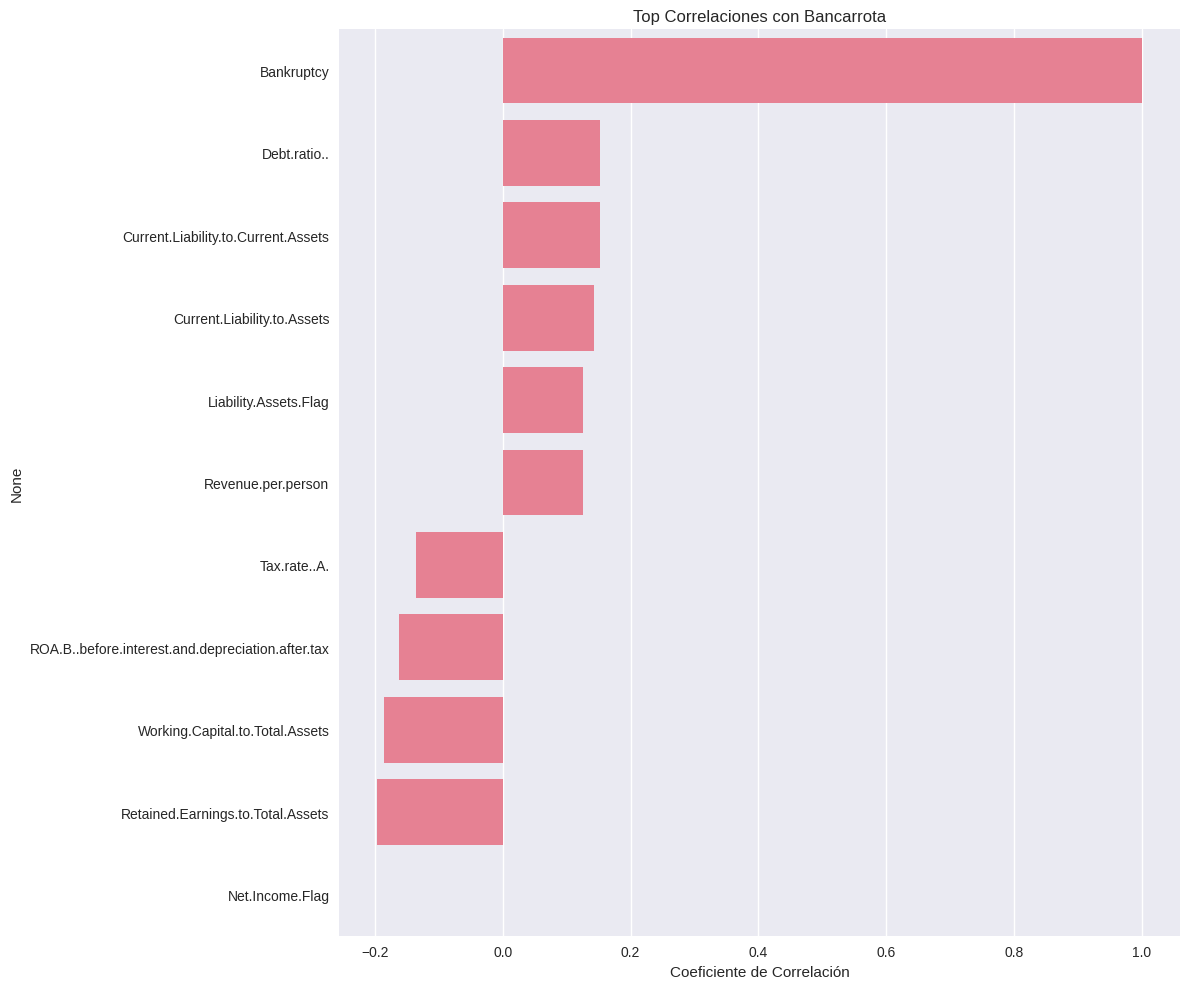

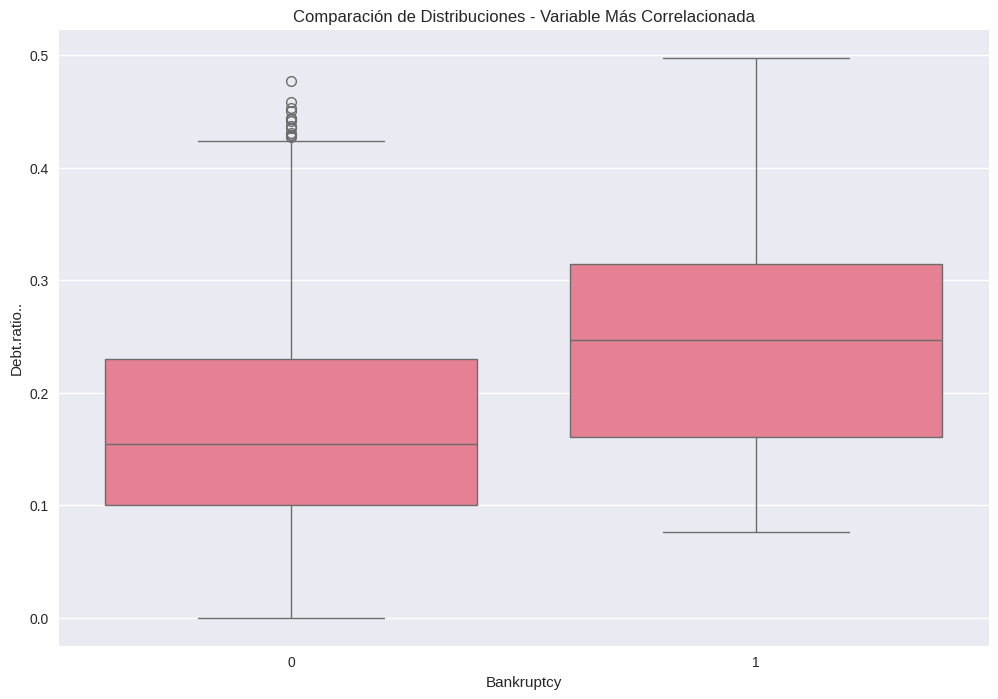

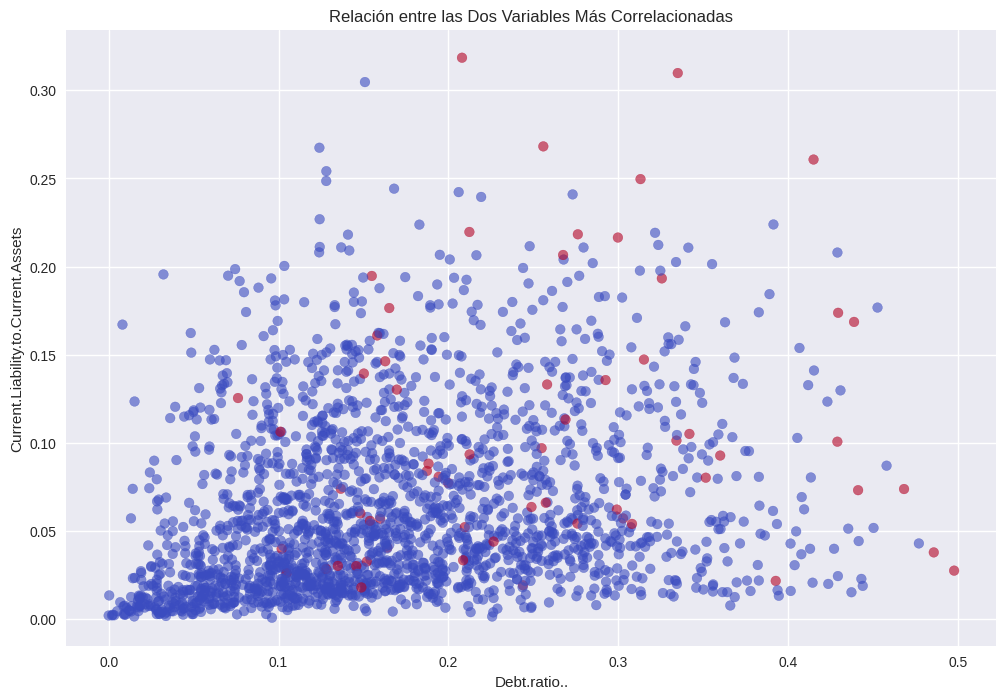

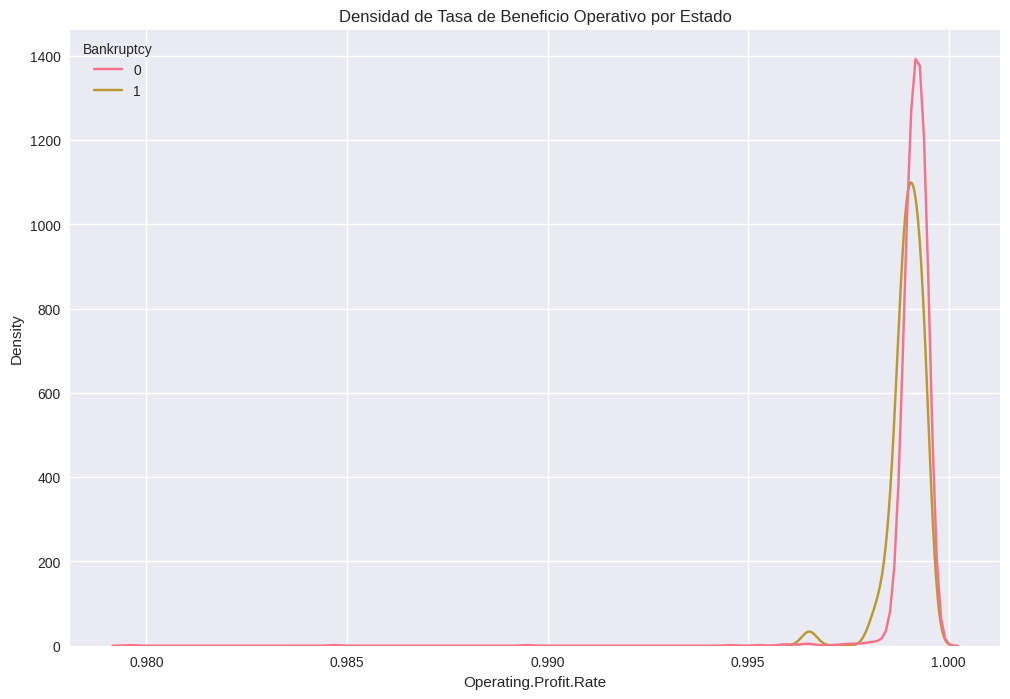

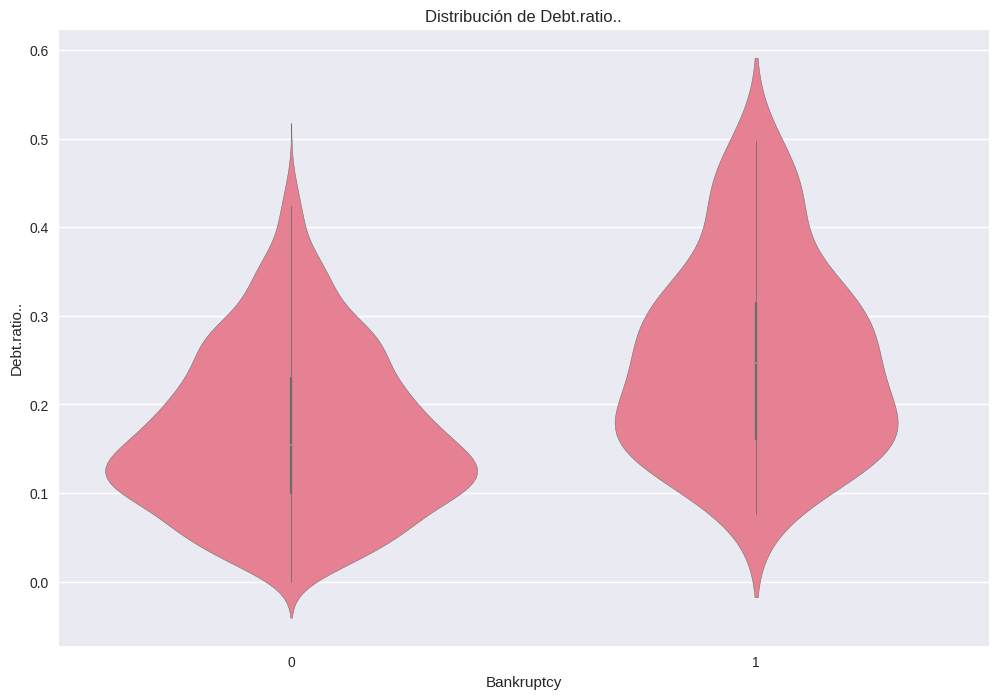

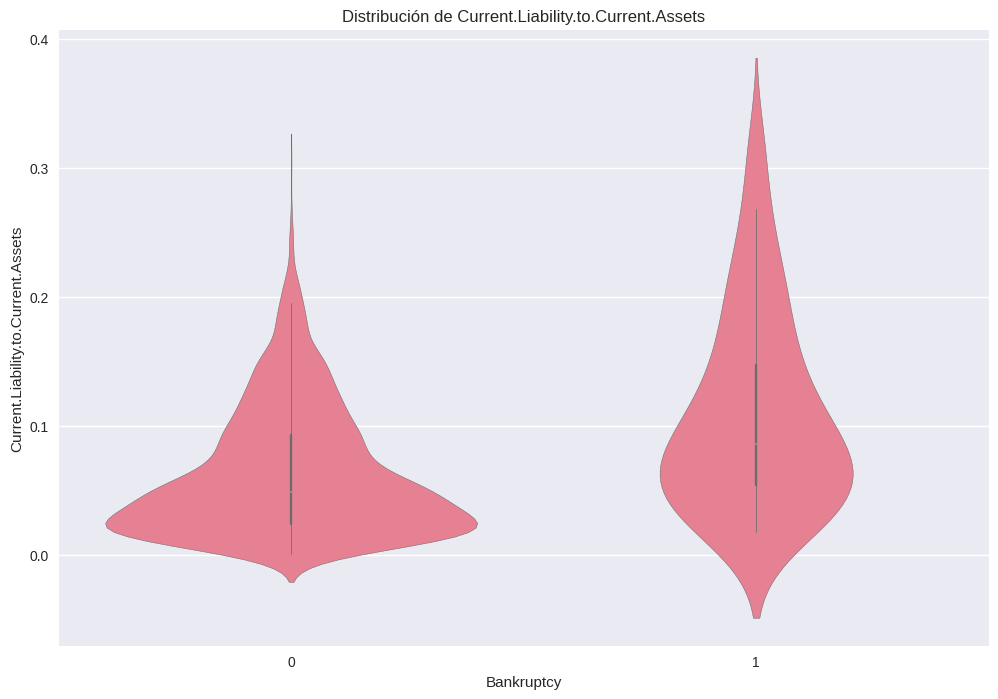

In [21]:
# Análisis de correlación
correlations = train_data.corr()['Bankruptcy'].sort_values(ascending=False)
print("\nTop 10 variables más positivamente correlacionadas con Bancarrota:")
print(correlations.head(11))
print("\nTop 10 variables más negativamente correlacionadas con Bancarrota:")
print(correlations.tail(10))

# Separar empresas
failed = train_data[train_data['Bankruptcy'] == 1]
healthy = train_data[train_data['Bankruptcy'] == 0]

# Top correlações
plt.figure(figsize=(12, 10))
top_corr = pd.concat([correlations.head(6), correlations.tail(5)])
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title('Top Correlaciones con Bancarrota')
plt.xlabel('Coeficiente de Correlación')
plt.tight_layout()
plt.savefig('../visualizaciones/07_top_correlaciones.png')
plt.show()

# Comparação de distribuições
important_vars = correlations.head(6).index.tolist()[1:]
plt.figure(figsize=(12, 8))
sns.boxplot(x='Bankruptcy', y=important_vars[0], data=train_data)
plt.title('Comparación de Distribuciones - Variable Más Correlacionada')
plt.savefig('../visualizaciones/08_distribucion_top_variable.png')
plt.show()

# Scatter plot
plt.figure(figsize=(12, 8))
var1, var2 = important_vars[0], important_vars[1]
plt.scatter(train_data[var1], train_data[var2], 
           c=train_data['Bankruptcy'], cmap='coolwarm', alpha=0.6)
plt.xlabel(var1)
plt.ylabel(var2)
plt.title('Relación entre las Dos Variables Más Correlacionadas')
plt.savefig('../visualizaciones/09_scatter_correlaciones.png')
plt.show()

# Densidade
plt.figure(figsize=(12, 8))
sns.kdeplot(data=train_data, x='Operating.Profit.Rate', 
           hue='Bankruptcy', common_norm=False)
plt.title('Densidad de Tasa de Beneficio Operativo por Estado')
plt.savefig('../visualizaciones/10_densidad_beneficio.png')
plt.show()

# Violin plots
plt.figure(figsize=(12, 8))
sns.violinplot(x='Bankruptcy', y=important_vars[0], data=train_data)
plt.title(f'Distribución de {important_vars[0]}')
plt.savefig('../visualizaciones/11_violin_var1.png')
plt.show()

plt.figure(figsize=(12, 8))
sns.violinplot(x='Bankruptcy', y=important_vars[1], data=train_data)
plt.title(f'Distribución de {important_vars[1]}')
plt.savefig('../visualizaciones/12_violin_var2.png')
plt.show()

## 5. Análisis de Componentes Principales (PCA)


Varianza explicada por componente:
PC1: 0.0716 (0.0716 acumulado)
PC2: 0.0680 (0.1397 acumulado)
PC3: 0.0586 (0.1983 acumulado)
PC4: 0.0535 (0.2518 acumulado)
PC5: 0.0457 (0.2975 acumulado)
PC6: 0.0424 (0.3399 acumulado)
PC7: 0.0399 (0.3798 acumulado)
PC8: 0.0374 (0.4172 acumulado)
PC9: 0.0349 (0.4521 acumulado)
PC10: 0.0331 (0.4852 acumulado)


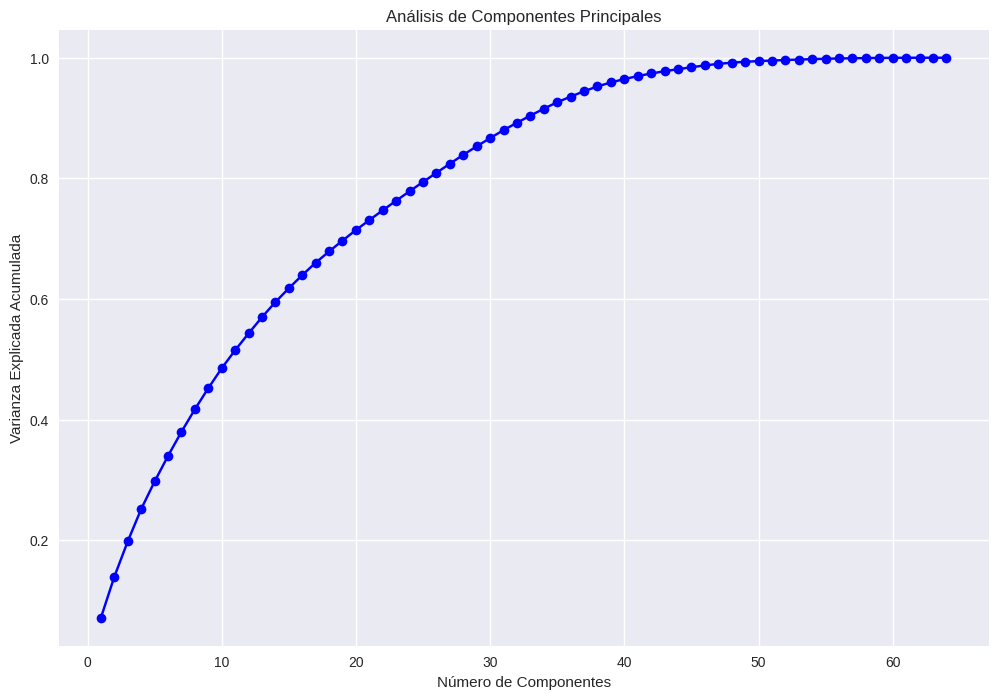

In [22]:
# Preparar datos para PCA
X = train_data[numeric_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("\nVarianza explicada por componente:")
for i, var in enumerate(explained_variance[:10]):
    print(f"PC{i+1}: {var:.4f} ({cumulative_variance[i]:.4f} acumulado)")

# PCA
plt.figure(figsize=(12, 8))
plt.plot(range(1, len(explained_variance) + 1), 
        cumulative_variance, 'bo-')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Análisis de Componentes Principales')
plt.grid(True)
plt.savefig('../visualizaciones/13_pca_varianza.png')
plt.show()

## 6. Análisis de Importancia de Variables


Top 10 variables más importantes (Mutual Information):
                                             Variable  Puntuación_MI
0                                          Bankruptcy       0.135834
5                                        Tax.rate..A.       0.021597
57                    Working.Capital.to.Total.Assets       0.019916
48                  Retained.Earnings.to.Total.Assets       0.016106
36                          Pre.tax.net.Interest.Rate       0.015785
15                          Inventory.Working.Capital       0.015310
45  ROA.B..before.interest.and.depreciation.after.tax       0.013671
55               Continuous.interest.rate..after.tax.       0.013588
29                        After.tax.net.Interest.Rate       0.013097
49                         Total.debt.Total.net.worth       0.012224


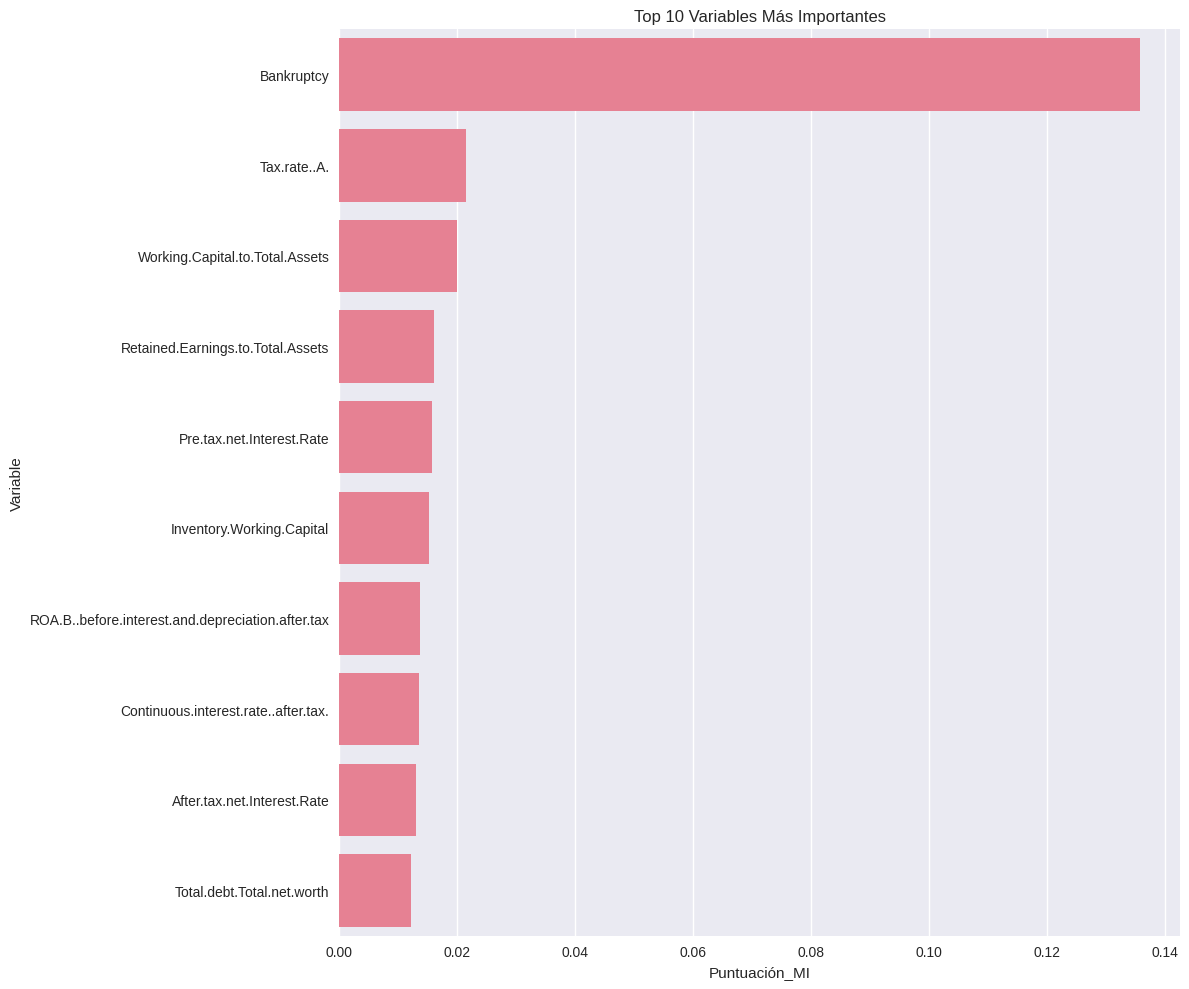

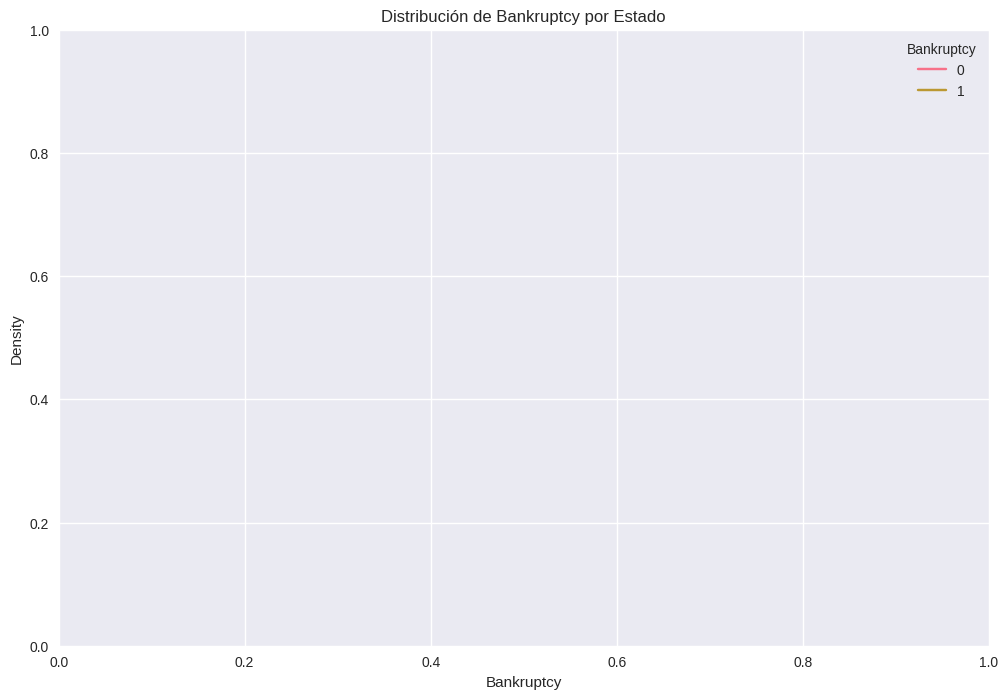

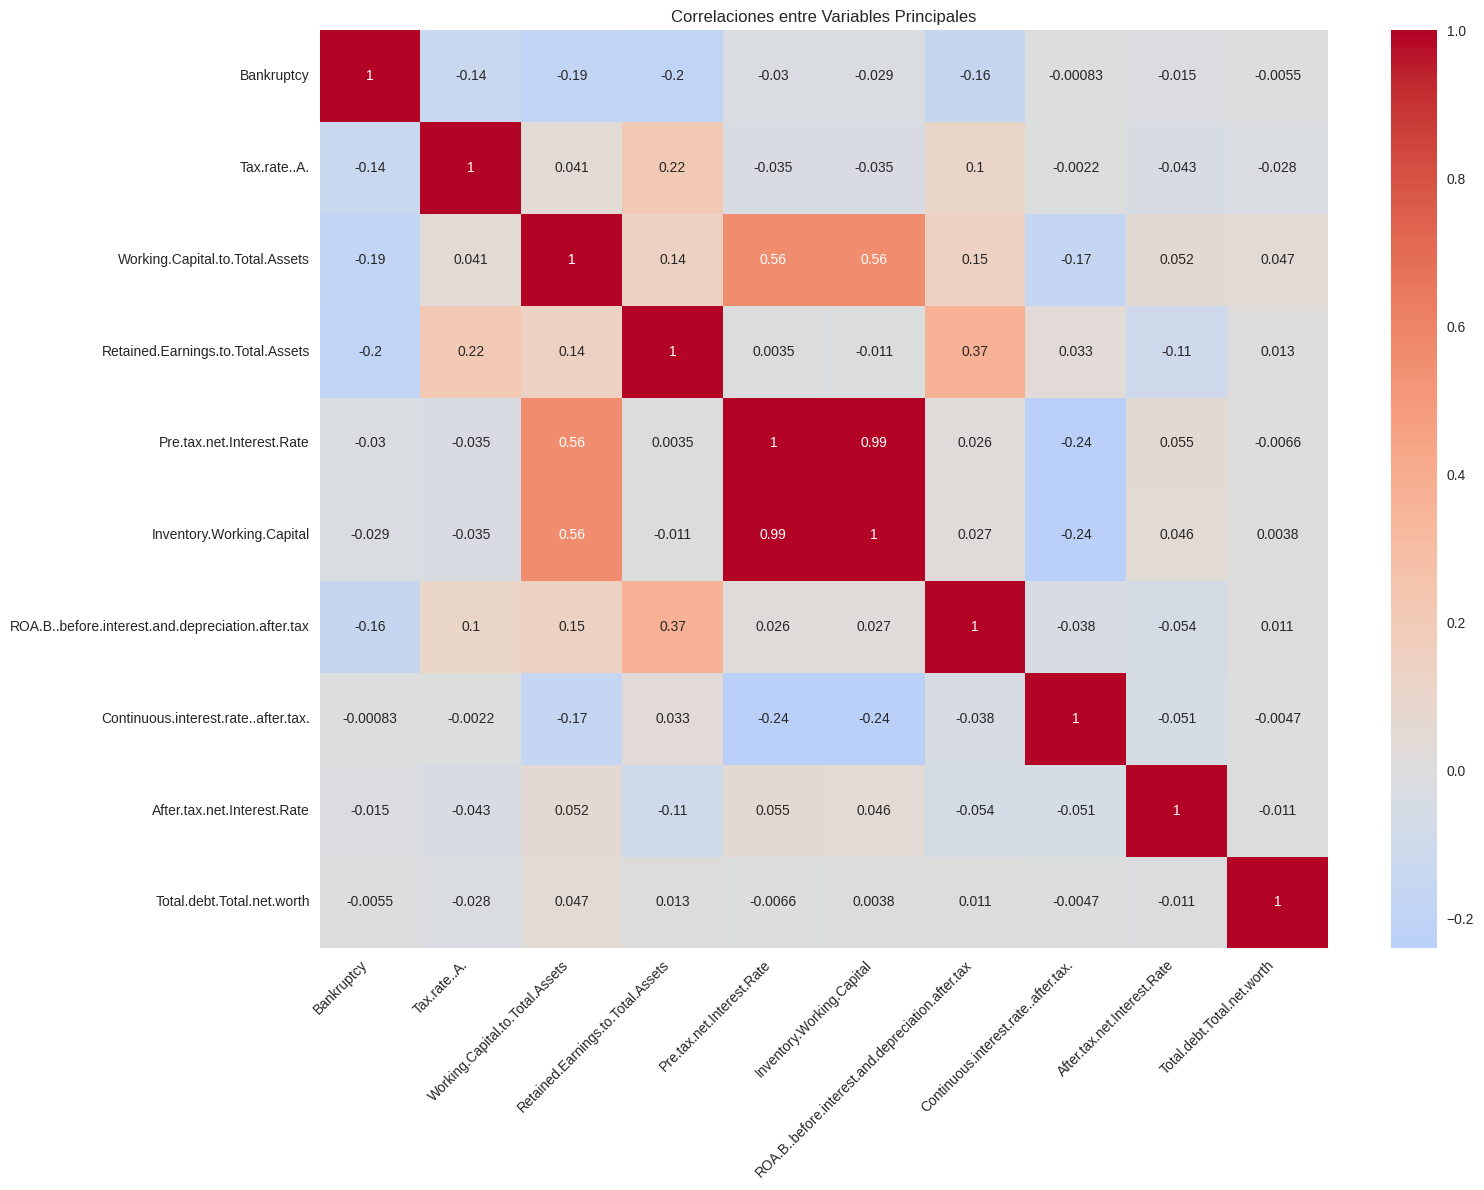

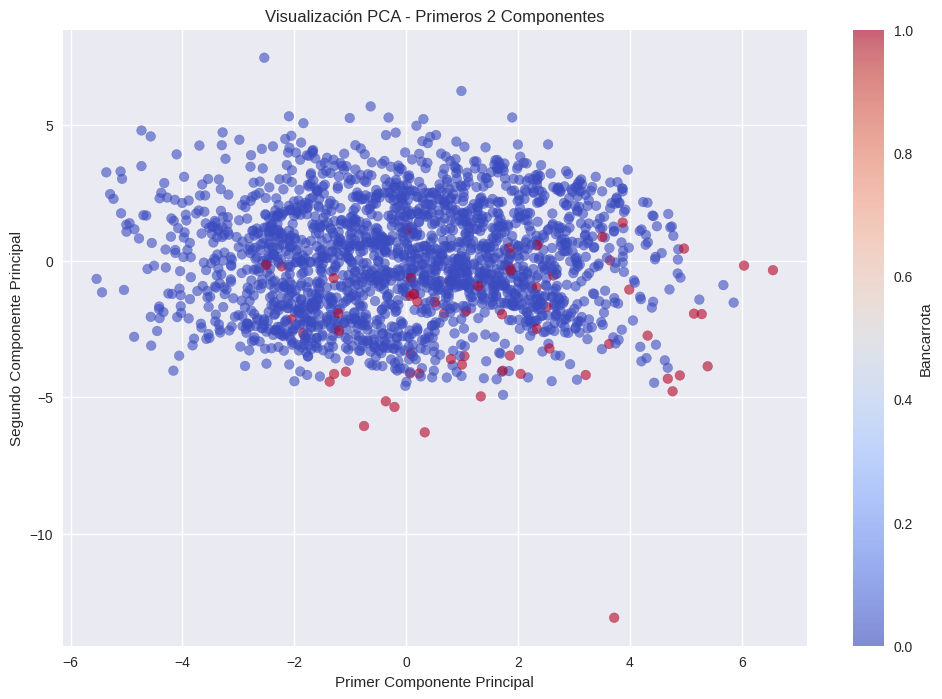

In [23]:
# Importância das features
mi_scores = mutual_info_classif(X_scaled, train_data['Bankruptcy'])
feature_importance = pd.DataFrame({
    'Variable': numeric_cols,
    'Puntuación_MI': mi_scores
}).sort_values('Puntuación_MI', ascending=False)

print("\nTop 10 variables más importantes (Mutual Information):")
print(feature_importance.head(10))

# Importância das features
plt.figure(figsize=(12, 10))
sns.barplot(data=feature_importance.head(10), 
           x='Puntuación_MI', y='Variable')
plt.title('Top 10 Variables Más Importantes')
plt.tight_layout()
plt.savefig('../visualizaciones/14_importancia_variables.png')
plt.show()

# Distribuições condicionais
plt.figure(figsize=(12, 8))
top_feature = feature_importance['Variable'].iloc[0]
sns.kdeplot(data=train_data, x=top_feature, 
           hue='Bankruptcy', common_norm=False)
plt.title(f'Distribución de {top_feature} por Estado')
plt.savefig('../visualizaciones/15_distribucion_top_mi.png')
plt.show()

# Matriz de correlação das top features
plt.figure(figsize=(16, 12))
top_features = feature_importance['Variable'].head(10).tolist()
sns.heatmap(train_data[top_features].corr(), 
           annot=True, cmap='coolwarm', center=0)
plt.title('Correlaciones entre Variables Principales')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../visualizaciones/16_correlacion_top_variables.png')
plt.show()

# Scatter plot PCA
plt.figure(figsize=(12, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_data['Bankruptcy'], cmap='coolwarm', alpha=0.6)
plt.xlabel('Primer Componente Principal')
plt.ylabel('Segundo Componente Principal')
plt.title('Visualización PCA - Primeros 2 Componentes')
plt.colorbar(label='Bancarrota')
plt.savefig('../visualizaciones/17_pca_scatter.png')
plt.show()